## Chapter 8 - Dimensionality Reduction

### Explained Variance Ratio / Proportion of Variance Explained

After a projection is complete, we ask how much of the information in a given dataset is lost by projection the observations to the first few principal components? In other words, how much of the variance in the data is not contained in the first few principal components? 

Generally, we want to find the proportion of variance explained (PVE) by each principal component. The total variance in a dataset is defined as:

$$\sum_{j=1}^p \text{Var}(X_j) = \sum_{j=1}^p\frac 1n \sum_{i=1}^n x^2_{ij}$$

and the variance explained by the $m$th principal component is:

$$\frac 1n \sum_{i=1}^n z^2_{im} = \frac 1n \sum_{i=1}^n\begin{pmatrix}\sum_{j=1}^p \phi_{jm}x_{ij}\end{pmatrix}^2$$

and hence the PVE of the $m$th principal component is:

$$\frac{\sum_{i=1}^n\begin{pmatrix}\sum_{j=1}^p \phi_{jm}x_{ij}\end{pmatrix}^2}{\sum_{j=1}^p \sum_{i=1}^n x^2_{ij}}$$

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA, IncrementalPCA

import matplotlib.pyplot as plt

def load(fname):
    import pickle
    mnist = None
    try:
        with open(fname, 'rb') as f:
            mnist = pickle.load(f)
            return mnist
    except FileNotFoundError:
        from sklearn.datasets import fetch_openml
        mnist = fetch_openml('mnist_784', version=1, cache=True)
        with open(fname, 'wb') as f:
            mnist = pickle.dump(mnist, f)
        return mnist

In [2]:
# Ingest
mnsit = load('mnist.data.pkl')
mnsit_X, mnsit_y = mnsit['data'], mnsit['target']

kf = KFold(n_splits=10, shuffle=True, random_state=0)
kf.get_n_splits()
t1 = []
for train_index, test_index in kf.split(mnsit_X, mnsit_y):
    t1 = test_index
    break
X = mnsit_X[t1]
y_test = mnsit_y[t1]

In [3]:
# Train the PCA model
pca = PCA(n_components=25**2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=625, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The PVE of each principal component is a positive quantity. In order to compute the cumulative PVE of the first $M$ principal components, we simply sum the PVE of the expression above.

The PVE of each principal component as well as the cumulative PVE can be shown in a scree plot.

<img src="0804.png" width="600" />

In [4]:
# Obtain the proportion of variance explained
var_df = pd.DataFrame({'evr' : pca.explained_variance_ratio_})
var_df['cum_vr'] = var_df['evr'].cumsum()
var_df['PC'] = var_df.index+1

In [5]:
# For testing
# print(var_df[:5])

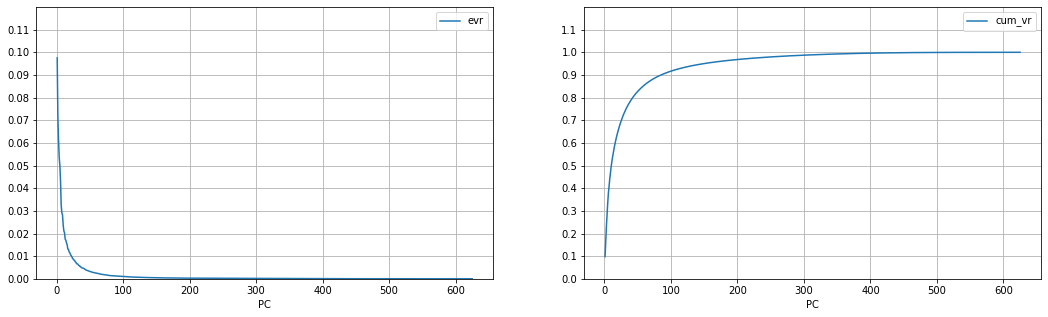

In [6]:
# Scree plot & Cumulative Variance explained plot 
fig= plt.figure(figsize=(18,5))
ax1, ax2 = fig.add_subplot(121),fig.add_subplot(122)
var_df.plot(kind='line', x='PC', y='evr', ax=ax1)
var_df.plot(kind='line', x='PC', y='cum_vr', ax=ax2)
ax1.set_ylim(0,0.12)
ax1.set_yticks([i/100 for i in range(0,12)])
ax2.set_ylim(0,1.2)
ax2.set_yticks([i/10 for i in range(0,12)])
ax1.grid()
ax2.grid()
plt.show()

In [7]:
# Choosing the right number of dimensions using 95% explanation,
num_features = np.argmax(var_df['cum_vr']>0.95)+1
print(num_features)
# Train with this selection
pca2 = PCA(n_components=num_features)
pca2.fit(X)

150


PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [8]:
# Fit using 95% explained variance directly using parameters
pca3 = PCA(n_components=0.95)
pca3.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [9]:
# For testing
# Validate that the n_components for both pca2 and pca3 are the same
# print(pca2.n_components_)
# print(pca3.n_components_)

Of course, we aim to use the smallest number of principal components to describe the data aptly. However, there is no good solution to this.

Generally, we use a scree plot to help us. Specifically, we look for a point where the proportion of variance explained by each subsequentn principal component drops off. It is referred to as the elbow in the scree plot. In the above example, the elbow after the second principal component. The third principal component captures 10% of the variance and the fourth principal component explains less that 5% and is essentially worthless.

Another thing to consider is to choose the number of dimensions that add up to a sufficiently large portion of the variance e.g. 95%.

### Incremental PCA

Instead of fitting the whole training set for the SVD algorithm to run, we can split the training set to mini-batches and run incremental PCA (IPCA), one batch at a time.

In [10]:
# Incremental PCA
n_batches = 100
incpca = IncrementalPCA(n_components=10)
for X_batch in np.array_split(X, n_batches):
    incpca.partial_fit(X_batch)

In [11]:
# Transform using the projection learnt after the incremental PCA
X_proj3 = incpca.transform(X)

### Randomised PCA

Another option for PCA is randomised PCA. This is a stochastic algorithm that quickly finds an approximation of the first $m$ principal components. It is faster when the number of principal components $m$ is much smaller than the number of observations $n$.

In [12]:
# Randomised PCA
rnd_pca = PCA(n_components=10, svd_solver='randomized')

In [13]:
# Transformation after using the projection learnt
X_proj4 = rnd_pca.fit_transform(X)